

# Image Segmentation

This notebook is adapted from this Keras Competition: [Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018)

### Nuclie Semantic Segmentation - UNet using Tensorflow 2

https://www.kaggle.com/advaitsave/tensorflow-2-nuclei-segmentation-unet/notebook

The datafiles downloaded below were obtained from the competition [Data Section](https://www.kaggle.com/c/data-science-bowl-2018/data) 


# LAB: RUN AND UNDERSTAND SOME OF THE FOLLOWING

- [TensorFlow Segmentation Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)
- [DeepLab](https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)
- [CitiScape Segmentation Demo](https://towardsdatascience.com/cityscape-segmentation-with-tensorflow-2-0-b320b6605cbf)

# Intro

- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'
FINAL_TEST_PATH = 'stage2_test_final/'

#TRAIN_PATH = 'data/stage1_train/'
#TEST_PATH = 'data/stage1_test/'
#FINAL_TEST_PATH = 'data/stage2_test_final/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

setting tensorflow version in colab
TensorFlow 2.x selected.


## Download and organize images

In [3]:
%%bash
rm -rf stage1_train*
rm -rf stage1_test*

wget -nc -q https://rlx.s3.amazonaws.com/stage1_train.zip
wget -nc -q https://rlx.s3.amazonaws.com/stage1_test.zip

mkdir -p stage1_train
mkdir -p stage1_test

cd stage1_train
unzip ../stage1_train.zip > /dev/null
cd ../stage1_test
unzip ../stage1_test.zip > /dev/null
cd ..
echo "images in train"
ls stage1_train |wc
echo "images in test"
ls stage1_test |wc

images in train
    670     670   43550
images in test
     65      65    4225


In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
#final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

# Preprocess the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [6]:

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        
        #Overlay individual masks to create a final mask for corresponding image
        mask = np.maximum(mask, mask_)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

print('Done!')



100%|██████████| 670/670 [06:29<00:00,  2.88it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 34.04it/s]

Done!


## Visualize imported data

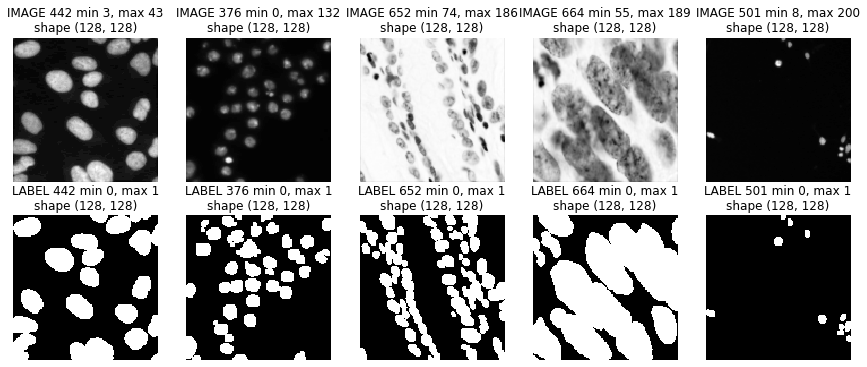

In [73]:
def show_img(img, title="", cmap=None, details=True):
    plt.imshow(img, cmap=cmap)
    if details:
        plt.title("%s min %d, max %d\nshape %s"%(title, np.min(img), np.max(img), str(img.shape)))
    else:
        plt.title(title)
    plt.axis("off")
    
plt.figure(figsize=(15,6))
ids = np.random.permutation(len(X_train))[:5]
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    show_img(X_train[i].mean(axis=2), "IMAGE %d"%i, cmap=plt.cm.Greys_r)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(Y_train[i]), "LABEL %d"%i, cmap=plt.cm.Greys_r)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


In [78]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 896         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 128, 128, 32) 128         conv2d_38[0][0]                  
____________________________________________________________________________________________

In [79]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.8830
Epoch 00001: val_loss improved from inf to 0.56334, saving model to model_unet_checkpoint.h5
603/603 [==============================] - 7s 11ms/sample - loss: 0.3448 - accuracy: 0.8833 - val_loss: 0.5633 - val_accuracy: 0.7957
Epoch 2/50
592/603 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9494
Epoch 00002: val_loss did not improve from 0.56334
603/603 [==============================] - 3s 6ms/sample - loss: 0.1913 - accuracy: 0.9498 - val_loss: 0.6411 - val_accuracy: 0.7960
Epoch 3/50
592/603 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9589
Epoch 00003: val_loss did not improve from 0.56334
603/603 [==============================] - 3s 6ms/sample - loss: 0.1496 - accuracy: 0.9589 - val_loss: 0.7239 - val_accuracy: 0.7959
Epoch 4/50
592/603 [============================>.] - ETA: 0s - loss: 0.


# Make predictions

In [70]:
# Predict on train, val and test
model = load_model('model_unet_checkpoint.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
X_val = X_train[int(X_train.shape[0]*0.9):]
Y_val = Y_train[int(X_train.shape[0]*0.9):]
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 1ms/sample


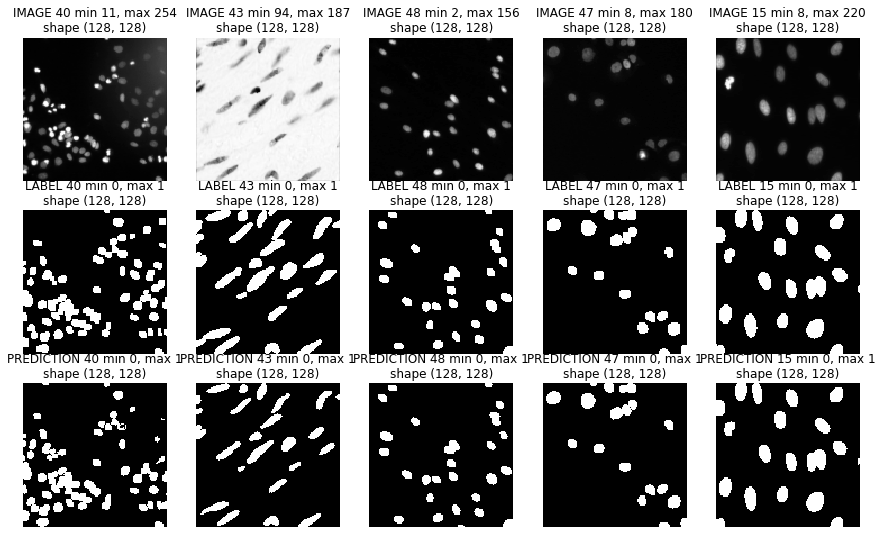

In [76]:
plt.figure(figsize=(15,9))
ids = np.random.permutation(len(preds_val))[:5]
for c,i in enumerate(ids):
    plt.subplot(3,5,c+1)
    show_img(X_train[int(X_train.shape[0]*0.9):][i].mean(axis=2), "IMAGE %d"%i, cmap=plt.cm.Greys_r)
    plt.subplot(3,5,c+6)
    show_img(np.squeeze(Y_train[int(X_train.shape[0]*0.9):][i]), "LABEL %d"%i, cmap=plt.cm.Greys_r)
    plt.subplot(3,5,c+11)
    show_img(np.squeeze(preds_val_t[i]), "PREDICTION %d"%i, cmap=plt.cm.Greys_r)